In [1]:
import networkx as nx
import osmnx as ox
import folium

ox.__version__

'2.0.1'

In [88]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import math

In [3]:
bus_stop_graph = ox.io.load_graphml("data/graph_bus_stop.graphml")
train_graph = ox.io.load_graphml("data/graph_train.graphml")

In [7]:
# Load the drive network for Berlin
walk_graph = ox.graph_from_place("Berlin, Germany", network_type="all", custom_filter='["highway"~"pedestrian"]')

### Load Amenities in Berlin

In [4]:
landuse_point_gdf = gpd.read_file("data/landuse_point_berlin.shp")
landuse_polygon_gdf = gpd.read_file("data/landuse_polygon_berlin.shp")

# Concatenate the two GeoDataFrames
landuse_gdf = gpd.GeoDataFrame(pd.concat([landuse_point_gdf, landuse_polygon_gdf], ignore_index=True))

leisure_point_gdf = gpd.read_file("data/feature_leisure_point_berlin.shp")
leisure_polygon_gdf = gpd.read_file("data/feature_leisure_polygon_berlin.shp")

# Concatenate the two GeoDataFrames
leisure_gdf = gpd.GeoDataFrame(pd.concat([leisure_point_gdf, leisure_polygon_gdf], ignore_index=True))

shop_point_gdf = gpd.read_file("data/feature_shop_point_berlin.shp")
shop_polygon_gdf = gpd.read_file("data/feature_shop_polygon_berlin.shp")

# Concatenate the two GeoDataFrames
shop_gdf = gpd.GeoDataFrame(pd.concat([shop_point_gdf, shop_polygon_gdf], ignore_index=True))

transports_point_gdf = gpd.read_file("data/feature_transports_point_berlin.shp")
transports_polygon_gdf = gpd.read_file("data/feature_transports_polygon_berlin.shp")

# Concatenate the two GeoDataFrames
transports_gdf = gpd.GeoDataFrame(pd.concat([transports_point_gdf, transports_polygon_gdf], ignore_index=True))

In [5]:
districts_point_gdf = gpd.read_file("data/districts_point_berlin.shp")
districts_polygon_gdf = gpd.read_file("data/districts_polygon_berlin.shp")

# Concatenate the two GeoDataFrames
berlin_districts = gpd.GeoDataFrame(pd.concat([districts_point_gdf, districts_polygon_gdf], ignore_index=True))
berlin_districts = berlin_districts.rename(columns={'admin_leve': 'admin_level'})

### Set Parameters for Commuting in Public Transport in Berlin

In [8]:
# Set travel speeds (in km/h) for each network
bus_speed_kph = 20  # Example bus speed
train_speed_kph = 30  # Example train speed
walk_speed_kph = 9  # Example walking speed

# Convert speeds to meters per minute
bus_speed_mpm = (bus_speed_kph * 1000) / 60
train_speed_mpm = (train_speed_kph * 1000) / 60
walk_speed_mpm = (walk_speed_kph * 1000) / 60

# Function to calculate travel time for edges
def set_travel_time(graph, speed_mpm):
    for u, v, k, data in graph.edges(keys=True, data=True):
        if "length" in data:
            # Calculate travel time based on length and speed
            data["travel_time"] = data["length"] / speed_mpm

# Apply travel time to each graph
set_travel_time(bus_stop_graph, bus_speed_mpm)
set_travel_time(train_graph, train_speed_mpm)
set_travel_time(walk_graph, walk_speed_mpm)

In [9]:
# Combine both graphs into a single MultiDiGraph
combined_graph = nx.compose(bus_stop_graph, train_graph)
combined_graph = nx.compose(combined_graph, walk_graph)

### Get Shortest Path

In [10]:
# Define origin and destination coordinates
# origin_lat, origin_lon = 52.52, 13.405  # Berlin center
# destination_lat, destination_lon = 52.50, 13.45
orig_point = ox.geocode("Alexanderplatz, Berlin, Germany")
dest_point = ox.geocode("Tiergarten, Berlin, Germany")

# Find the nearest nodes for origin and destination
orig_node = ox.distance.nearest_nodes(combined_graph, orig_point[1], orig_point[0])

finding_dest_graph = combined_graph.copy()
finding_dest_graph.remove_nodes_from([orig_node])
dest_node = ox.distance.nearest_nodes(finding_dest_graph, dest_point[1], dest_point[0])

# Calculate the shortest path using the custom travel time
shortest_path = nx.shortest_path(combined_graph, orig_node, dest_node, weight="travel_time")

# Calculate total travel time
total_travel_time = sum(combined_graph[u][v][0]["travel_time"] for u, v in zip(shortest_path[:-1], shortest_path[1:]))
print(f"Total Travel Time: {total_travel_time:.2f} minutes")

Total Travel Time: 21.50 minutes


### Get Points on Map Within 10 Minute Travel Distance

In [13]:
# Calculate 10 minutes in meters
travel_distance = train_speed_mpm * 10  # 10-minute distance in meters

# Get the nearest node to the coordinate
orig_node = ox.distance.nearest_nodes(combined_graph, orig_point[1], orig_point[0])

# Create the polygon using an isochrone (area reachable within travel distance)
isochrone_subgraph = nx.ego_graph(combined_graph, orig_node, radius=travel_distance, distance="length")
isochrone_polygon = ox.convert.graph_to_gdfs(isochrone_subgraph, nodes=False, edges=True)["geometry"].union_all().convex_hull

# Convert the polygon and points to the same CRS for proper comparison
isochrone_gdf = gpd.GeoDataFrame(geometry=[isochrone_polygon], crs="EPSG:4326")

# Count points within the polygon
points_within = shop_gdf[shop_gdf.within(isochrone_polygon)]
num_points_within = len(points_within)

print(f"Number of points within the 10-minute polygon: {num_points_within}")

Number of points within the 10-minute polygon: 5566


C:\Users\naimi\AppData\Local\Temp\ipykernel_19700\2821276607.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


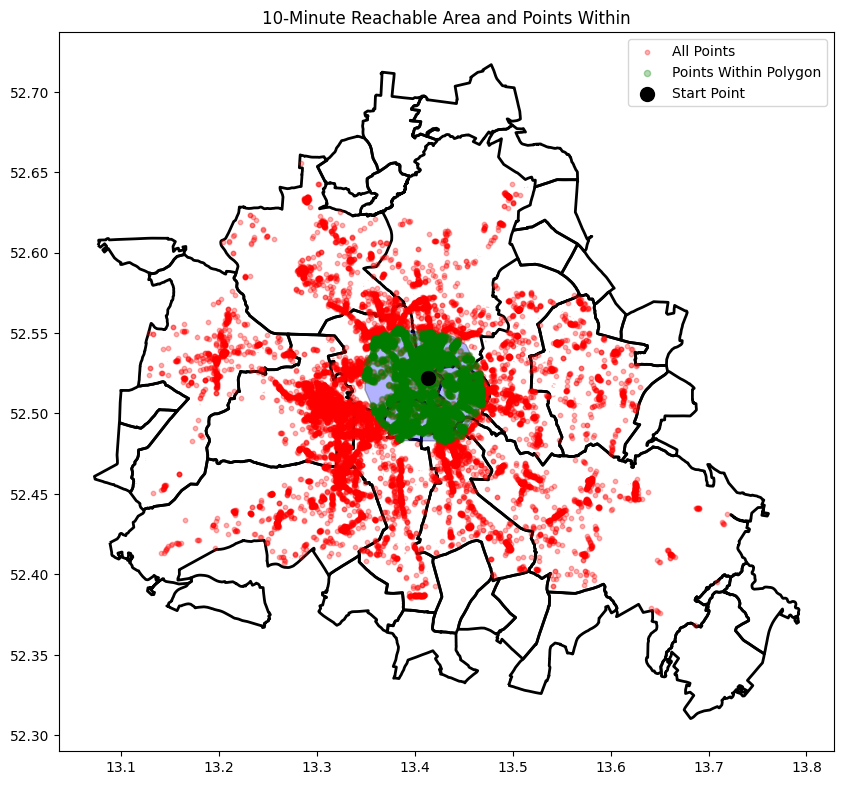

In [14]:
# Plot the polygon and points
fig, ax = plt.subplots(figsize=(10, 10))

berlin_districts[(berlin_districts.geometry.type == 'Polygon') & (berlin_districts['admin_level'] == '9')].plot(edgecolor="black", facecolor="none", linewidth=2, ax=ax)

# Plot the isochrone polygon
isochrone_gdf.plot(ax=ax, color="blue", alpha=0.3, edgecolor="black")

# Plot all points
shop_gdf.plot(ax=ax, color="red", markersize=10, label="All Points", alpha=0.3)

# Highlight points within the polygon
points_within.plot(ax=ax, color="green", markersize=20, label="Points Within Polygon", alpha=0.3)

# Plot the starting location
plt.scatter(orig_point[1], orig_point[0], c="black", s=100, label="Start Point")

plt.legend()
plt.title("10-Minute Reachable Area and Points Within")
plt.show()

In [52]:
# Calculate 10 minutes in meters
travel_distance = train_speed_mpm * 10  # 10-minute distance in meters

district_amenities = {}

for district in landuse_gdf['district n'].unique():
    residentials = landuse_gdf[(landuse_gdf['landuse'] == 'residential') & (landuse_gdf['district n'] == district)]

    # leisure_within = []
    # shop_within = []
    leisure_col = ['source node'] + list(leisure_gdf.columns)
    shop_col = ['source node'] + list(shop_gdf.columns)
    leisure_within = gpd.GeoDataFrame(columns=leisure_col)
    shop_within = gpd.GeoDataFrame(columns=shop_col)

    for i in residentials.index[:100]:
        curr_res = residentials.loc[i]
        geo_point = curr_res['geometry']

        if geo_point.geom_type == 'Polygon':
            geo_point = geo_point.centroid
        
        # Get the nearest node to the coordinate
        orig_node = ox.distance.nearest_nodes(combined_graph, geo_point.x, geo_point.y)

        if combined_graph.degree(orig_node) == 0:
            print("The node is isolated and has no edges.")

            # Create an empty row with all null values and append the empty row to the GeoDataFrame
            empty_row = pd.DataFrame([{col: None for col in shop_within.columns}])
            empty_row['source node'] = orig_node
            shop_within = pd.concat([shop_within, empty_row], ignore_index=True)

            empty_row = pd.DataFrame([{col: None for col in leisure_within.columns}])
            empty_row['source node'] = orig_node
            leisure_within = pd.concat([leisure_within, empty_row], ignore_index=True)
            continue

        # Create the polygon using an isochrone (area reachable within travel distance)
        isochrone_subgraph = nx.ego_graph(combined_graph, orig_node, radius=travel_distance, distance="length")
        isochrone_polygon = ox.convert.graph_to_gdfs(isochrone_subgraph, nodes=False, edges=True)["geometry"].union_all().convex_hull

        # Convert the polygon and points to the same CRS for proper comparison
        isochrone_gdf = gpd.GeoDataFrame(geometry=[isochrone_polygon], crs="EPSG:4326")

        # Count points within the polygon
        points_within = shop_gdf[shop_gdf.within(isochrone_polygon)]
        points_within['source node'] = [orig_node for point in range(len(points_within))]
        # shop_within.append(points_within)
        shop_within = gpd.GeoDataFrame(pd.concat([shop_within, points_within], ignore_index=True))

        points_within = leisure_gdf[leisure_gdf.within(isochrone_polygon)]
        points_within['source node'] = [orig_node for point in range(len(points_within))]
        # leisure_within.append(points_within)
        leisure_within = gpd.GeoDataFrame(pd.concat([leisure_within, points_within], ignore_index=True))

        # num_points_within = len(points_within)
    
    district_amenities[district] = {}
    district_amenities[district]['leisure'] = leisure_within
    district_amenities[district]['shop'] = shop_within

district_amenities

c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

The node is isolated and has no edges.


C:\Users\naimi\AppData\Local\Temp\ipykernel_19700\3836511774.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shop_within = pd.concat([shop_within, empty_row], ignore_index=True)
C:\Users\naimi\AppData\Local\Temp\ipykernel_19700\3836511774.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  leisure_within = pd.concat([leisure_within, empty_row], ignore_index=True)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying 

The node is isolated and has no edges.


c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

The node is isolated and has no edges.
The node is isolated and has no edges.


c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

{'Treptow-Köpenick': {'leisure':       source node element          id        leisure amenity  \
  0      5783247761    node   536387498     playground    None   
  1      5783247761    node   536387502     playground    None   
  2      5783247761    node   691264855          sauna    None   
  3      5783247761    node   799289307         marina    None   
  4      5783247761    node  1358382380          pitch    None   
  ...           ...     ...         ...            ...     ...   
  37456  5300421724     way  1304296615           park    None   
  37457  5300421724     way  1304329870  sports_centre    None   
  37458  5300421724     way  1304329883         garden    None   
  37459  5300421724     way  1330405220          pitch    None   
  37460  5300421724     way  1330405224          pitch    None   
  
                                     name addr_city addr_postc  \
  0                                  None      None       None   
  1                                  None 

In [19]:
list(district_amenities.keys())

['Treptow-Köpenick',
 'Friedrichshain-Kreuzberg',
 None,
 'Spandau',
 'Lichtenberg',
 'Charlottenburg-Wilmersdorf',
 'Tempelhof-Schöneberg',
 'Neukölln',
 'Steglitz-Zehlendorf',
 'Mitte',
 'Marzahn-Hellersdorf',
 'Reinickendorf',
 'Dahlwitz-Hoppegarten']

In [54]:
agg_col = ['district name', 'source node', 'amenity node', 'leisure/shop', 'amenity type', 'amenity', 'geometry']

agg_gdf = gpd.GeoDataFrame(columns=agg_col)

for district in district_amenities.keys():
    if district == None:
        continue


    new_gdf = gpd.GeoDataFrame(columns=agg_col)

    leisures = district_amenities[district]['leisure']
    
    new_gdf['district name'] = [district for i in range(len(leisures))]
    new_gdf['source node'] = leisures['source node']
    new_gdf['amenity node'] = leisures['id']
    new_gdf['leisure/shop'] = 'leisure'
    new_gdf['amenity type'] = leisures['leisure']
    new_gdf['amenity'] = leisures['amenity']
    new_gdf['geometry'] = leisures['geometry']

    agg_gdf = gpd.GeoDataFrame(pd.concat([agg_gdf, new_gdf], ignore_index=True))
    new_gdf = gpd.GeoDataFrame(columns=agg_col)

    shops = district_amenities[district]['shop']
    
    new_gdf = gpd.GeoDataFrame(columns=agg_col)
    new_gdf['district name'] = [district for i in range(len(shops))]
    new_gdf['source node'] = shops['source node']
    new_gdf['amenity node'] = shops['id']
    new_gdf['leisure/shop'] = 'shop'
    new_gdf['amenity type'] = shops['shop']
    new_gdf['amenity'] = shops['amenity']
    new_gdf['geometry'] = shops['geometry']

    agg_gdf = gpd.GeoDataFrame(pd.concat([agg_gdf, new_gdf], ignore_index=True))

agg_gdf

,district name,source node,amenity node,leisure/shop,amenity type,amenity,geometry
0,Treptow-Köpenick,5783247761,536387498,leisure,playground,None,POINT (13.60158 52.44007)
1,Treptow-Köpenick,5783247761,536387502,leisure,playground,None,POINT (13.60277 52.44069)
2,Treptow-Köpenick,5783247761,691264855,leisure,sauna,None,POINT (13.54483 52.43735)
3,Treptow-Köpenick,5783247761,799289307,leisure,marina,None,POINT (13.58381 52.42363)
4,Treptow-Köpenick,5783247761,1358382380,leisure,pitch,None,POINT (13.54387 52.40646)
...,...,...,...,...,...,...,...
3703527,Dahlwitz-Hoppegarten,4004265257,480452097,shop,car_repair,None,"POLYGON ((13.6068 52.48941, 13.60693 52.48937,..."
3703528,Dahlwitz-Hoppegarten,4004265257,712942837,shop,florist,None,"POLYGON ((13.57397 52.48653, 13.57412 52.4865,..."
3703529,Dahlwitz-Hoppegarten,4004265257,824613716,shop,supermarket,None,"POLYGON ((13.60602 52.49014, 13.60592 52.48986..."
3703530,Dahlwitz-Hoppegarten,4004265257,1153970098,shop,car,None,"POLYGON ((13.60652 52.49062, 13.60711 52.49046..."


In [58]:
agg_gdf[agg_gdf.geometry.type == "Point"].to_file("data/agg_100_point_berlin.shp")
agg_gdf[agg_gdf.geometry.type == "Polygon"].to_file("data/agg_100_polygon_berlin.shp")

C:\Users\naimi\AppData\Local\Temp\ipykernel_19700\1668540404.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  agg_gdf[agg_gdf.geometry.type == "Point"].to_file("data/agg_100_point_berlin.shp")
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'district name' to 'district n'
  ogr_write(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source node' to 'source nod'
  ogr_write(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'amenity node' to 'amenity no'
  ogr_write(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'leisure/shop' to 'leisure/sh'
  ogr_write(
c:\Users\naimi\anaconda3\envs\dads\lib\site-packages\pyogrio\raw.py:723: RuntimeWarn

### Sorting Amenity Type for Table Visualization

In [55]:
sorted_shops = agg_gdf[agg_gdf['leisure/shop'] == 'shop'].groupby(['district name', 'amenity type']).agg({
    'amenity node': 'count'
}).sort_values(by=['amenity node', 'district name'], ascending=False)
table_shops_labels = list(sorted_shops.index.get_level_values('amenity type').unique())
table_shops_labels

sorted_leisures = agg_gdf[agg_gdf['leisure/shop'] == 'leisure'].groupby(['district name', 'amenity type']).agg({
    'amenity node': 'count'
}).sort_values(by=['amenity node', 'district name'], ascending=False)
table_leisures_labels = list(sorted_leisures.index.get_level_values('amenity type').unique())
table_leisures_labels

['garden',
 'pitch',
 'playground',
 'park',
 'swimming_pool',
 'sports_centre',
 'fitness_centre',
 'outdoor_seating',
 'picnic_table',
 'fitness_station',
 'track',
 'sports_hall',
 'dance',
 'parklet',
 'adult_gaming_centre',
 'bleachers',
 'hackerspace',
 'dog_park',
 'sauna',
 'escape_game',
 'amusement_arcade',
 'stadium',
 'marina',
 'miniature_golf',
 'music_venue',
 'bird_hide',
 'bowling_alley',
 'tanning_salon',
 'firepit',
 'schoolyard',
 'ice_rink',
 'bandstand',
 'slipway',
 'nature_reserve',
 'parket',
 'table',
 'horse_riding',
 'swimming_area',
 'pit',
 'ceramic_painting',
 'wellness',
 'event_location',
 'water_park;sauna',
 'concert_location',
 'golf_course',
 'indoor_play',
 'sport',
 'common',
 'indoor_playground',
 'flightsimulation',
 'disc_golf_course',
 'arena',
 'grandstand',
 'hammock',
 'gymnasium',
 'trampoline_park',
 'high_ropes_course',
 'seat',
 'cultural_institution',
 'construction',
 'beach_resort',
 'paddling_pool',
 'water_park',
 'crane',
 'halfpi

In [101]:
# Plot table for leisures 
table_cols = table_leisures_labels
table_rows = agg_gdf['district name'].unique()

grouped_geom_leisures = agg_gdf[(agg_gdf['leisure/shop'] == 'leisure')].groupby(['district name', 'amenity type']).aggregate({
    'source node': pd.Series.nunique, 'amenity type': 'count'
}).sort_values(by='source node', ascending=False)
grouped_geom_leisures

source node  amenity type
district name            amenity type                            
Spandau                  sports_centre           86          1290
                         park                    86          5335
Steglitz-Zehlendorf      swimming_pool           84          2286
                         park                    84         14658
                         pitch                   84         32941
...                                             ...           ...
Friedrichshain-Kreuzberg hammock                  1             1
Mitte                    beach_resort             1             1
Marzahn-Hellersdorf      marina                   1             6
                         escape_game              1             2
Treptow-Köpenick         arena                    1             1

[476 rows x 2 columns]

In [74]:
# Plot table for shops 
table_cols = table_shops_labels
table_rows = agg_gdf['district name'].unique()

grouped_geom_shops = agg_gdf[(agg_gdf['leisure/shop'] == 'shop')].groupby(['district name', 'amenity type']).aggregate({
    'source node': pd.Series.nunique, 'amenity type': 'count'
}).sort_values(by='source node', ascending=False)
grouped_geom_shops

source node  \
district name            amenity type                               
Spandau                  supermarket                           86   
Steglitz-Zehlendorf      books                                 84   
                         bakery                                84   
                         supermarket                           83   
                         hairdresser                           83   
...                                                           ...   
Dahlwitz-Hoppegarten     interior_decoration                    1   
                         hairdresser                            1   
Treptow-Köpenick         coffee_machines                        1   
Dahlwitz-Hoppegarten     greengrocer                            1   
Friedrichshain-Kreuzberg dry_cleaning;laundry;tailor            1   

                                                      amenity type  
district name            amenity type                               
Spandau                  supermarket                          2678  
Steglitz-Zehlendorf      books                                2145  
                         bakery                               8937  
                         supermarket                          8592  
                         hairdresser                         15008  
...                                                            ...  
Dahlwitz-Hoppegarten     interior_decoration                     1  
                         hairdresser                             4  
Treptow-Köpenick         coffee_machines                         1  
Dahlwitz-Hoppegarten     greengrocer                             1  
Friedrichshain-Kreuzberg dry_cleaning;laundry;tailor             2  

[1986 rows x 2 columns]

In [102]:
# Save the MultiIndex DataFrame to a CSV file
grouped_geom_shops.to_csv('data/agg_grouped_100_Berlin_shops.csv')
grouped_geom_leisures.to_csv('data/agg_grouped_100_Berlin_leisures.csv')

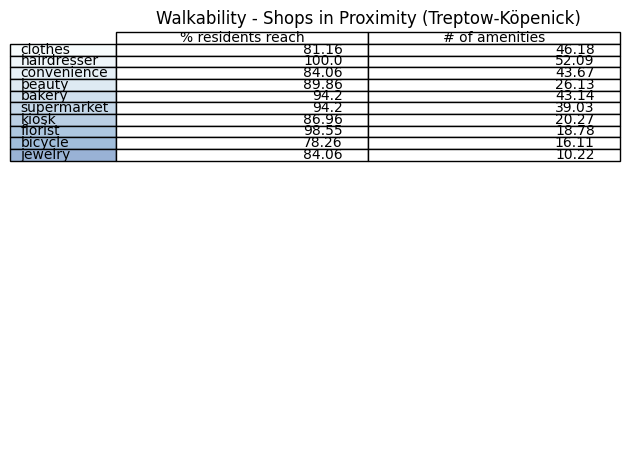

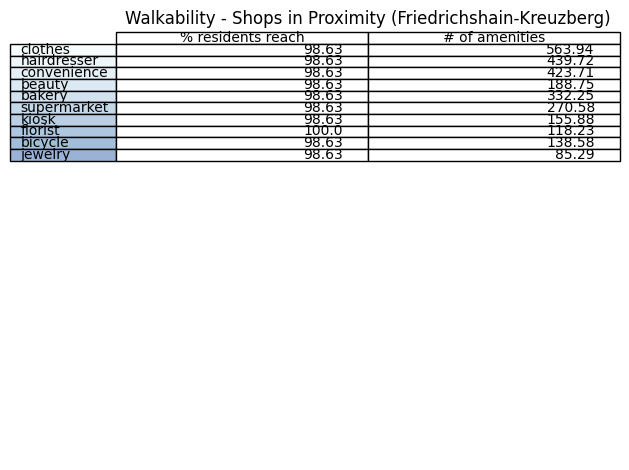

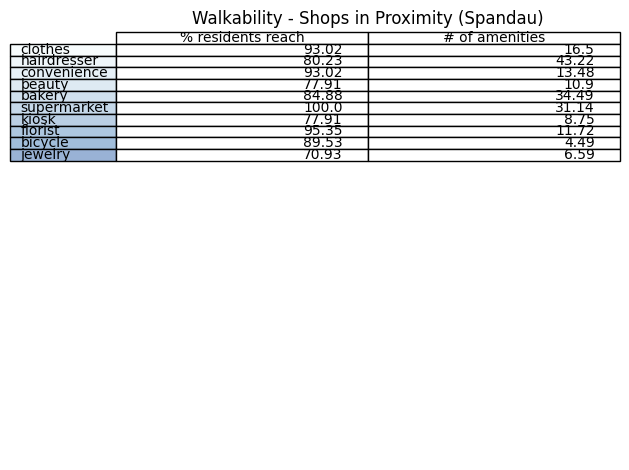

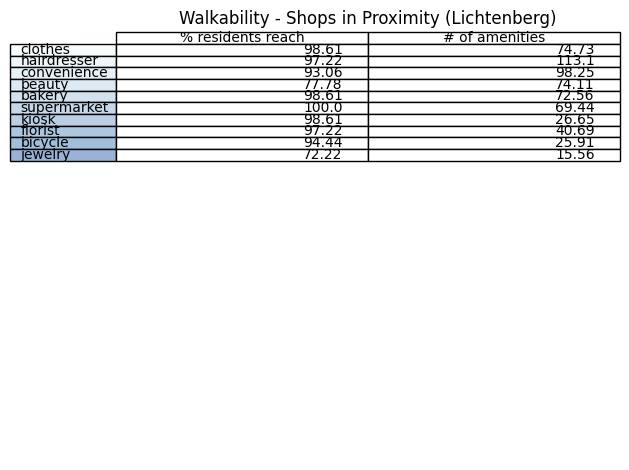

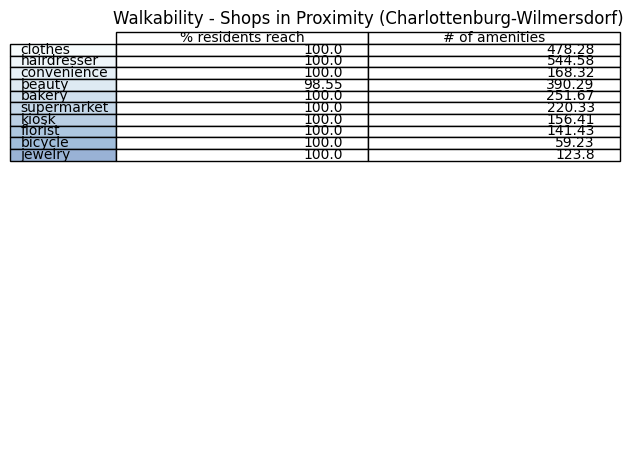

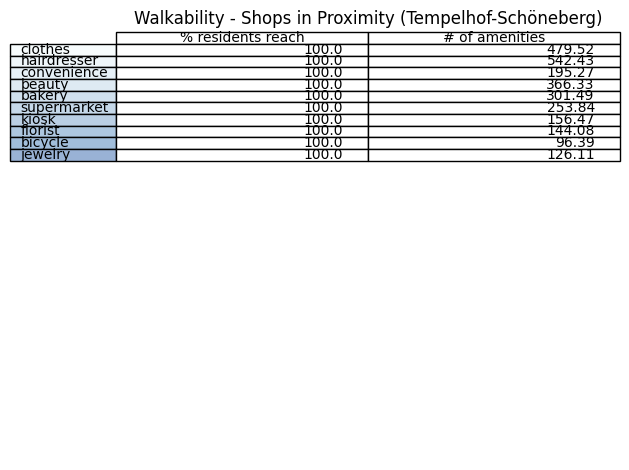

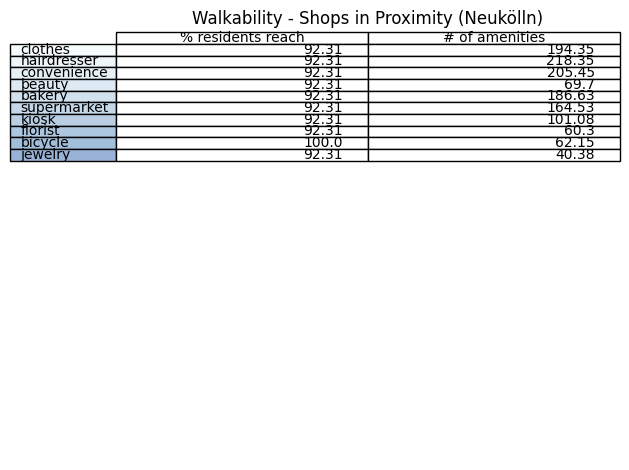

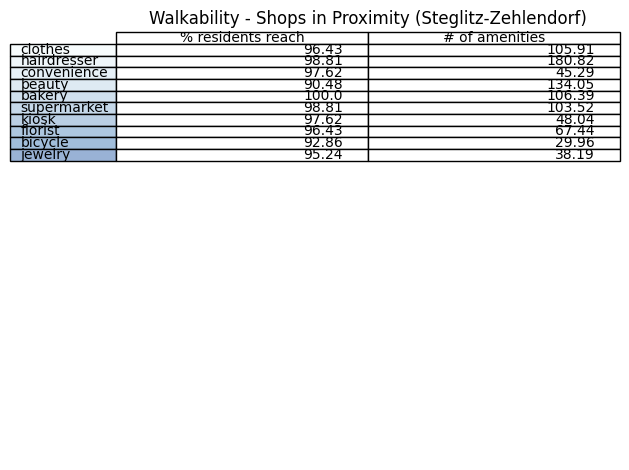

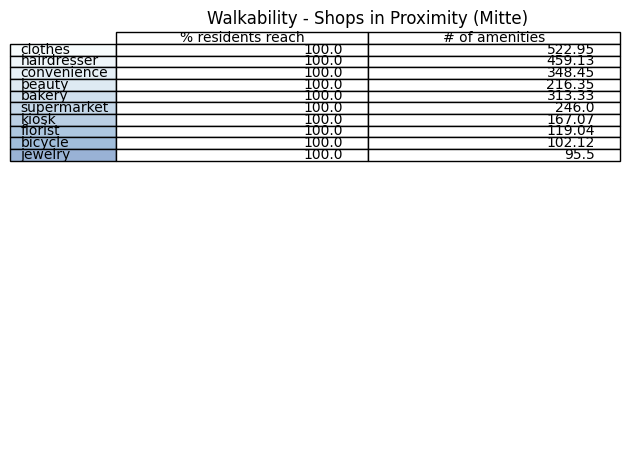

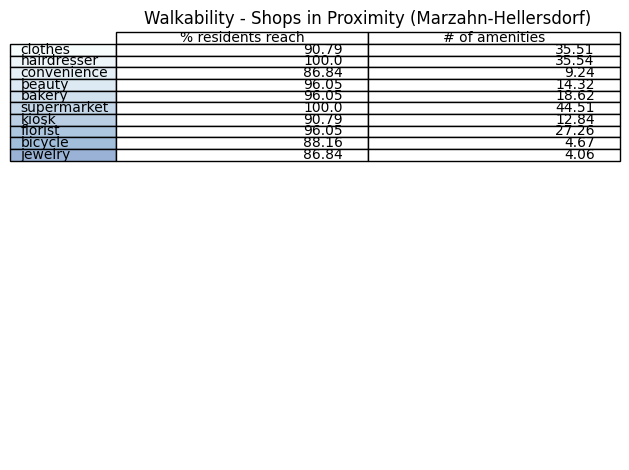

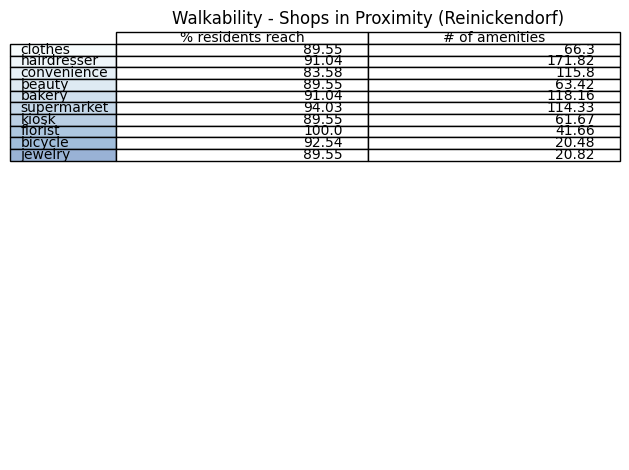

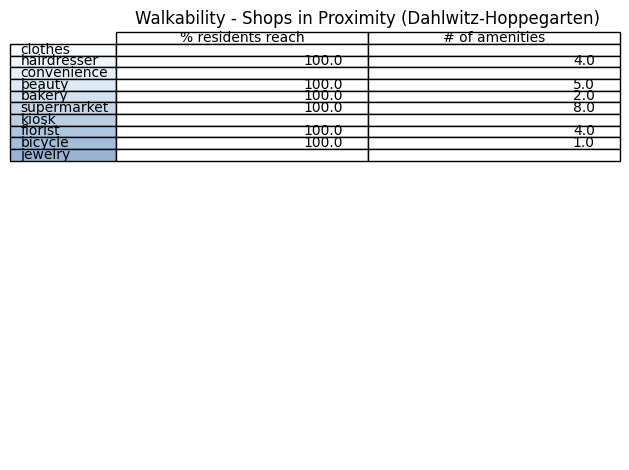

In [100]:
for district in agg_gdf['district name'].unique():

    max_residents = grouped_geom_shops.loc[district]['source node'].max()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Hide the axis
    ax.axis('off')
    plot_text = []
    plot_col = ['% residents reach', '# of amenities']
    plot_rows = table_shops_labels[:10]

    for shop in plot_rows:
        if shop not in grouped_geom_shops.loc[district].index.get_level_values('amenity type'):
            plot_text.append([None, None])
            continue
        # plot_textplot_gdf = grouped_geom_shops
        plot_text.append([round((grouped_geom_shops.loc[district, shop]['source node']/max_residents*100), 2), round(grouped_geom_shops.loc[district, shop]['amenity type']/grouped_geom_shops.loc[district, shop]['source node'], 2)])

    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(table_rows)))
    table = plt.table(cellText=plot_text,
                        rowLabels=plot_rows,
                        rowColours=colors,
                        colLabels=plot_col,
                        bbox=[0, 0.7, 1, 0.3])
    plt.title(f'Walkability - Shops in Proximity ({district})')
    # Automatically adjust layout to minimize blank space
    plt.tight_layout()
    plt.show()

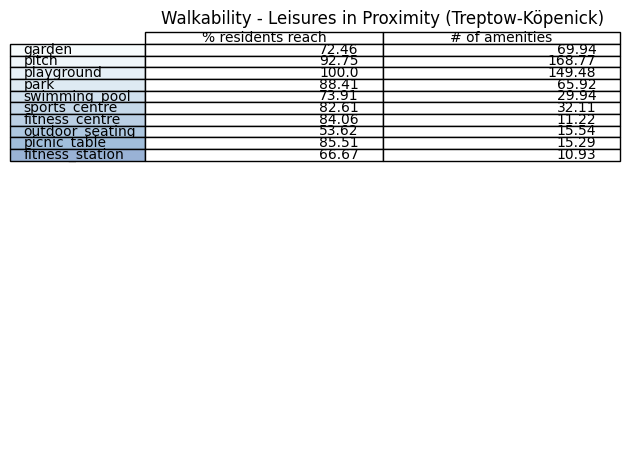

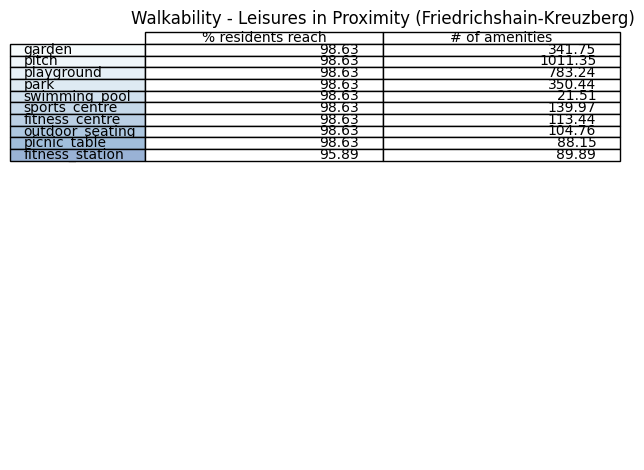

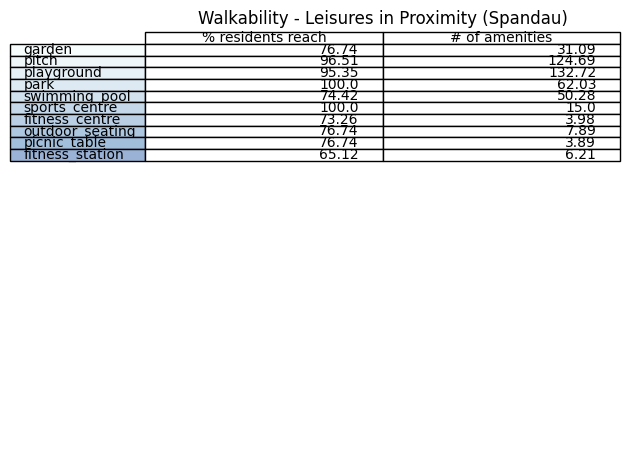

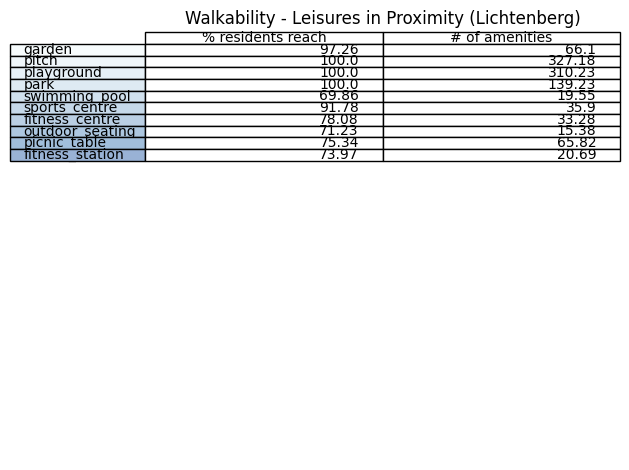

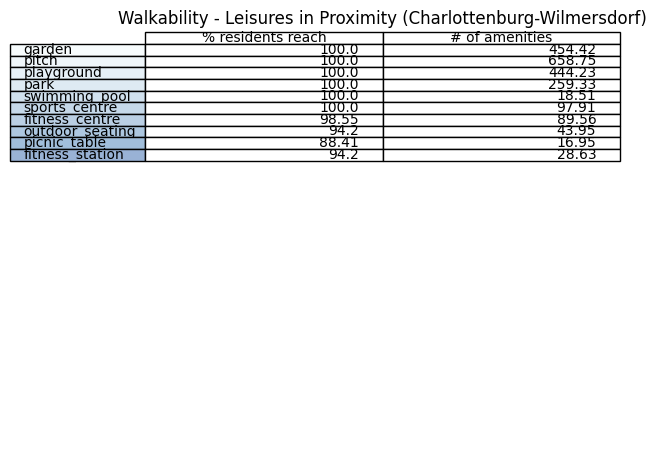

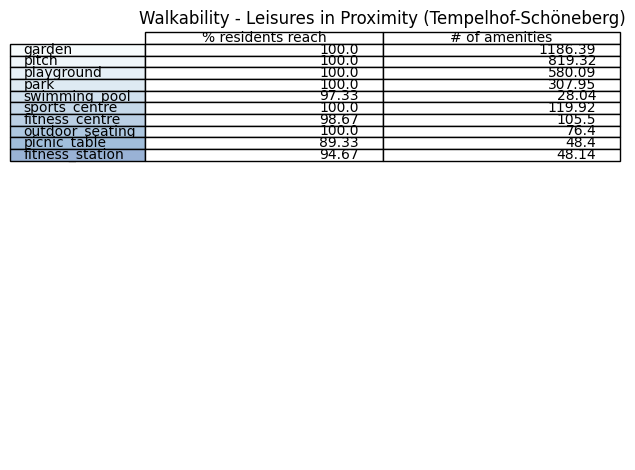

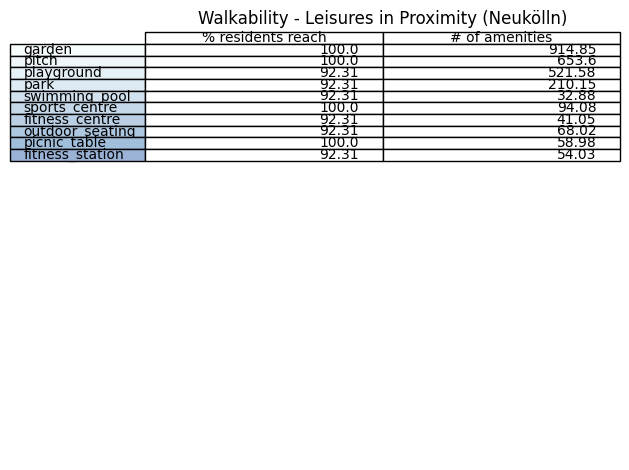

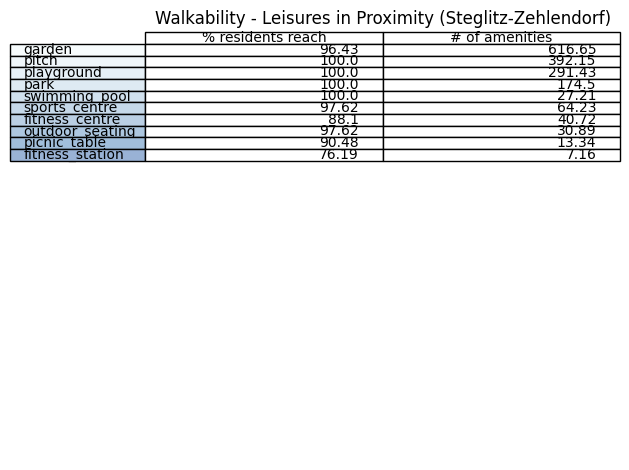

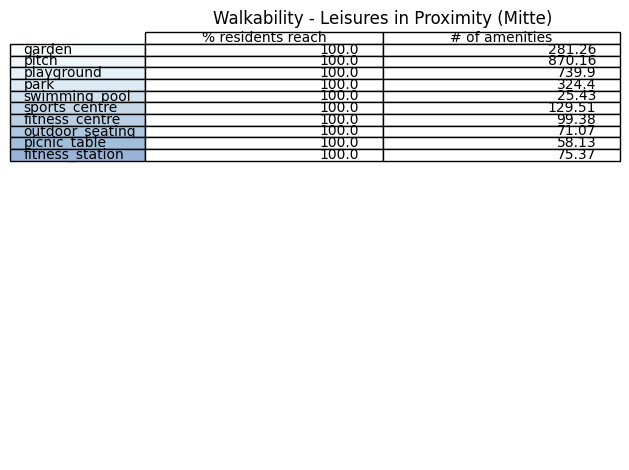

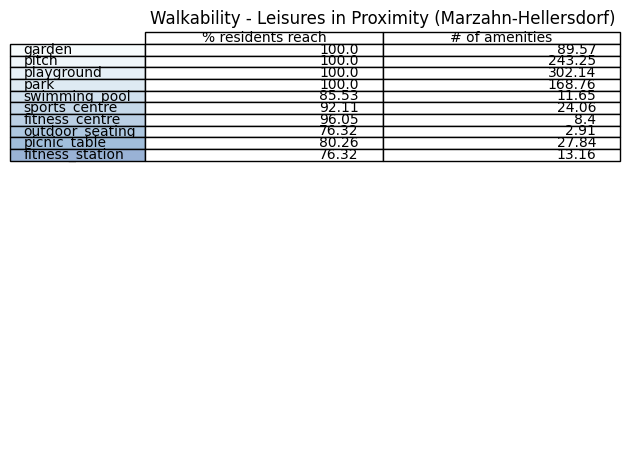

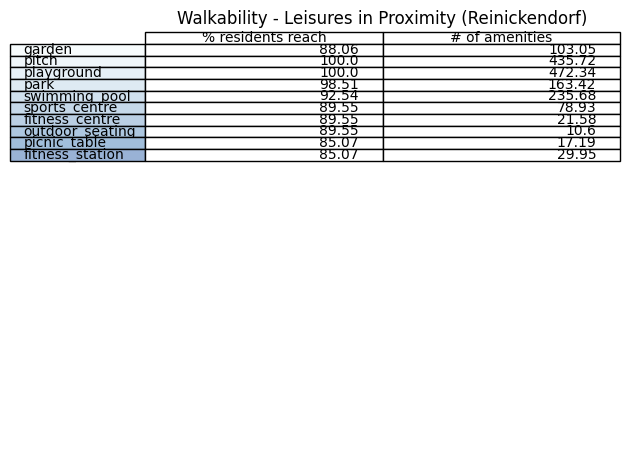

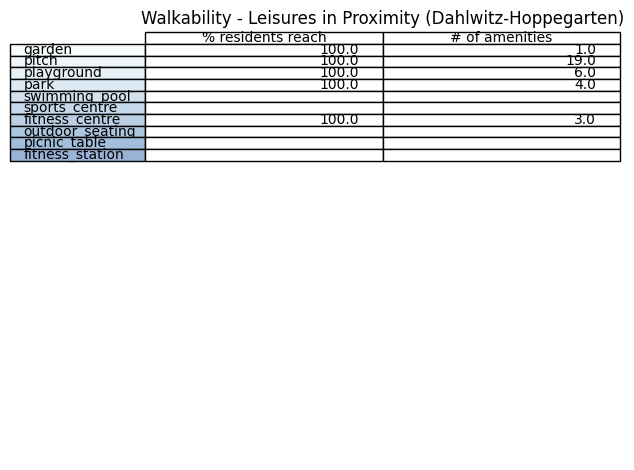

In [103]:
for district in agg_gdf['district name'].unique():

    max_residents = grouped_geom_leisures.loc[district]['source node'].max()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Hide the axis
    ax.axis('off')
    plot_text = []
    plot_col = ['% residents reach', '# of amenities']
    plot_rows = table_leisures_labels[:10]

    for leisure in plot_rows:
        if leisure not in grouped_geom_leisures.loc[district].index.get_level_values('amenity type'):
            plot_text.append([None, None])
            continue
        # plot_textplot_gdf = grouped_geom_shops
        plot_text.append([round((grouped_geom_leisures.loc[district, leisure]['source node']/max_residents*100), 2), round(grouped_geom_leisures.loc[district, leisure]['amenity type']/grouped_geom_leisures.loc[district, leisure]['source node'], 2)])

    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(table_rows)))
    table = plt.table(cellText=plot_text,
                        rowLabels=plot_rows,
                        rowColours=colors,
                        colLabels=plot_col,
                        bbox=[0, 0.7, 1, 0.3])
    plt.title(f'Walkability - Leisures in Proximity ({district})')
    # Automatically adjust layout to minimize blank space
    plt.tight_layout()
    plt.show()